In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore')
import io

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('../Data/final_table.csv')
df = df.drop(columns= ['Unnamed: 0', 'flightdate'])

In [3]:
## giving ranking for airline based on the proportion of delay (2019) from the EDA 

In [4]:
df_2019 = df[(df['year'] == 2019)]
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39344 entries, 0 to 86659
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             39344 non-null  int64  
 1   quarter                          39344 non-null  int64  
 2   month                            39344 non-null  int64  
 3   dayofmonth                       39344 non-null  int64  
 4   dayofweek                        39344 non-null  int64  
 5   flight_number_reporting_airline  39344 non-null  int64  
 6   originairportid                  39344 non-null  int64  
 7   destairportid                    39344 non-null  int64  
 8   destcitymarketid                 39344 non-null  int64  
 9   destwac                          39344 non-null  int64  
 10  crsdeptime                       39344 non-null  int64  
 11  crsarrtime                       39344 non-null  int64  
 12  arrdel15          

In [5]:
df_2019['airline'].unique()

array(['Endeavor Air Inc.', 'Southwest Airlines Co.',
       'Mesa Airlines Inc.', 'Republic Airline', 'PSA Airlines Inc.',
       'United Air Lines Inc.', 'Delta Air Lines Inc.',
       'SkyWest Airlines Inc.', 'American Airlines Inc.',
       'Spirit Air Lines', 'Alaska Airlines Inc.', 'JetBlue Airways',
       'Allegiant Air', 'Frontier Airlines Inc.',
       'Hawaiian Airlines Inc.', 'Envoy Air', 'ExpressJet Airlines LLC'],
      dtype=object)

In [6]:
ranking = df_2019[['airline']]
dictionary = {
    'ExpressJet Airlines LLC':1,
    'JetBlue Airways':1,
    'Envoy Air': 1,
    'Allegiant Air': 1,
    'Frontier Airlines Inc.': 1,
    'PSA Airlines Inc.': 2,
    'Alaska Airlines Inc.': 2,
    'Mesa Airlines Inc.': 2, 
    'American Airlines Inc.': 2, 
    'Hawaiian Airlines Inc.' : 3, 
    'United Air Lines Inc.': 3, 
    'Republic Airline': 3, 
    'Southwest Airlines Co.': 3, 
    'SkyWest Airlines Inc.': 4,
    'Spirit Air Lines': 4,
    'Delta Air Lines Inc.': 4, 
    'Endeavor Air Inc.': 4
}

for i in ranking:
    df_2019.replace({i:dictionary}, inplace = True)

In [7]:
df_2019['airline'].unique()

array([4, 3, 2, 1], dtype=int64)

dummy= pd.get_dummies(df_2019['destcity'])

df_2019 = pd.concat([df_2019,dummy], axis = 1)
df_2019 = df_2019.drop(columns = ['destcity'])
df_2019.head()

In [8]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39344 entries, 0 to 86659
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             39344 non-null  int64  
 1   quarter                          39344 non-null  int64  
 2   month                            39344 non-null  int64  
 3   dayofmonth                       39344 non-null  int64  
 4   dayofweek                        39344 non-null  int64  
 5   flight_number_reporting_airline  39344 non-null  int64  
 6   originairportid                  39344 non-null  int64  
 7   destairportid                    39344 non-null  int64  
 8   destcitymarketid                 39344 non-null  int64  
 9   destwac                          39344 non-null  int64  
 10  crsdeptime                       39344 non-null  int64  
 11  crsarrtime                       39344 non-null  int64  
 12  arrdel15          

In [9]:
x2 = df_2019.drop(columns = ['arrdel15', 'destcity'], axis = 1)
y2 = df_2019.arrdel15

#train test split
x_train, x_test, y_train, y_test = train_test_split(x2, y2, stratify=y2, random_state = 42)


print(x_train.shape, y_train.shape)

(29508, 18) (29508,)


In [10]:
y2.value_counts()

0.0    31834
1.0     7510
Name: arrdel15, dtype: int64

In [11]:
def score(model,x_train, x_test):
    
    """
    This function scores the model by returning the confusion matrix and classification report of the model
    
    """
    
    # Get predictions
    preds = model.predict(x_test)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Flight Not Delay','Flight Delay']).plot(cmap='GnBu')

    print("Training Score:",model.score(x_train,y_train))
    print("Testing Score:",model.score(x_test,y_test))
    print("\n")
    print(classification_report(y_test, preds))

In [12]:
def roc(model, model_name, x_train, x_test): 
    
    """
    This function generates the ROC/AUC curve of the model.
    
    Due to the imbalanced nature of the data, the preferred metrics for this project is ROC/AUC.
    
    """      
    
    plt.figure(figsize=(16,10))
    
    # Predict probabilities from X_test
    df = pd.DataFrame(model.predict_proba(x_test))
    preds = df.drop(columns=0)
    
    # 
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)

    df2 = pd.DataFrame(model.predict_proba(x_train))
    preds2 = df2.drop(columns=0)
    fpr2, tpr2, _ = roc_curve(y_train, preds2)
    auc2 = roc_auc_score(y_train, preds2)
    
    with sns.axes_style(style="darkgrid"):
        plt.plot(fpr,tpr,color='orange',label="%s test, auc=%s" %(model_name, format(auc,".3f")))
        plt.plot(fpr2,tpr2,color='blue',label="%s train, auc=%s" %(model_name, format(auc2,".3f")))
        plt.plot(y_test,y_test,color='gray',linestyle=':') #baseline 50%
    plt.legend(loc='lower right')    
    
    sns.despine(left=True,bottom=True)

In [13]:
preprocess_pipe = make_pipeline(MinMaxScaler())

In [14]:
#create pipeline
lr_pipe = make_pipeline(LogisticRegression(max_iter=200, random_state = 42))
    

# define grid params for logistic regression
lr_params = {
    'logisticregression__C': [0.02, 0.05, 0.1],
    'logisticregression__solver' : ['newton-cg','saga', 'sag', 'lbfgs'],
    'logisticregression__multi_class': ['multinomial', 'ovr', 'auto'],
    'logisticregression__penalty':['l1','l2','elasticnet'],
    'logisticregression__l1_ratio':[None, 0.25,0.5,0.75],
    'logisticregression__class_weight':[None, 'balanced']
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_lr = GridSearchCV(lr_pipe, param_grid = lr_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [15]:
x_train_t = preprocess_pipe.fit_transform(x_train)
x_test_t = preprocess_pipe.transform(x_test)

In [16]:
grid_lr.fit(x_train_t,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression(max_iter=200,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.02, 0.05, 0.1],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__l1_ratio': [None, 0.25, 0.5,
                                                          0.75],
                         'logisticregression__multi_class': ['multinomial',
                                                             'ovr', 'auto'],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'saga',
                                                        'sag', 'lbfgs']},
       

In [17]:
print("best score", grid_lr.best_score_)
print("best params", grid_lr.best_params_)

best score 0.6417212066329966
best params {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__l1_ratio': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


Training Score: 0.6478235603023694
Testing Score: 0.6419178256599167


              precision    recall  f1-score   support

         0.0       0.86      0.60      0.71      7959
         1.0       0.26      0.60      0.36      1877

    accuracy                           0.60      9836
   macro avg       0.56      0.60      0.54      9836
weighted avg       0.75      0.60      0.64      9836



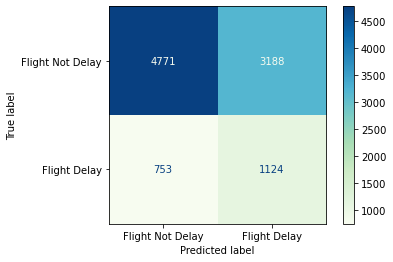

In [18]:
score(grid_lr, x_train_t, x_test_t)

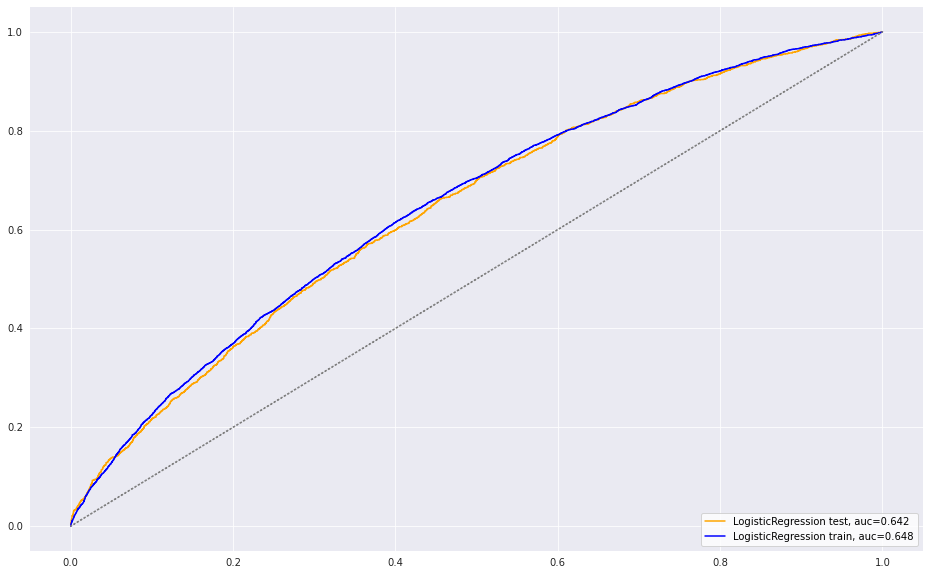

In [19]:
roc(grid_lr,"LogisticRegression", x_train_t, x_test_t)

In [20]:
importance = grid_lr.best_estimator_.named_steps['logisticregression'].coef_[0]
importance

array([ 0.        , -0.0428006 ,  0.        ,  0.01619616, -0.00918311,
        0.17906651,  0.01706539,  0.        , -0.10000909, -0.06840318,
        0.74821971,  0.2183696 , -2.52353807,  5.90140371,  0.        ,
       -1.57461189, -0.84414753, -0.18384223])

In [21]:
feature_importance = pd.DataFrame({'features' :x_train.columns,
                                   'coefficient' : abs(importance)}).sort_values(by='coefficient',
                                                                                         ascending = False)
 

In [22]:
feature_importance['rank'] = feature_importance['coefficient'].rank(ascending = False)
feature_importance = feature_importance[:10]

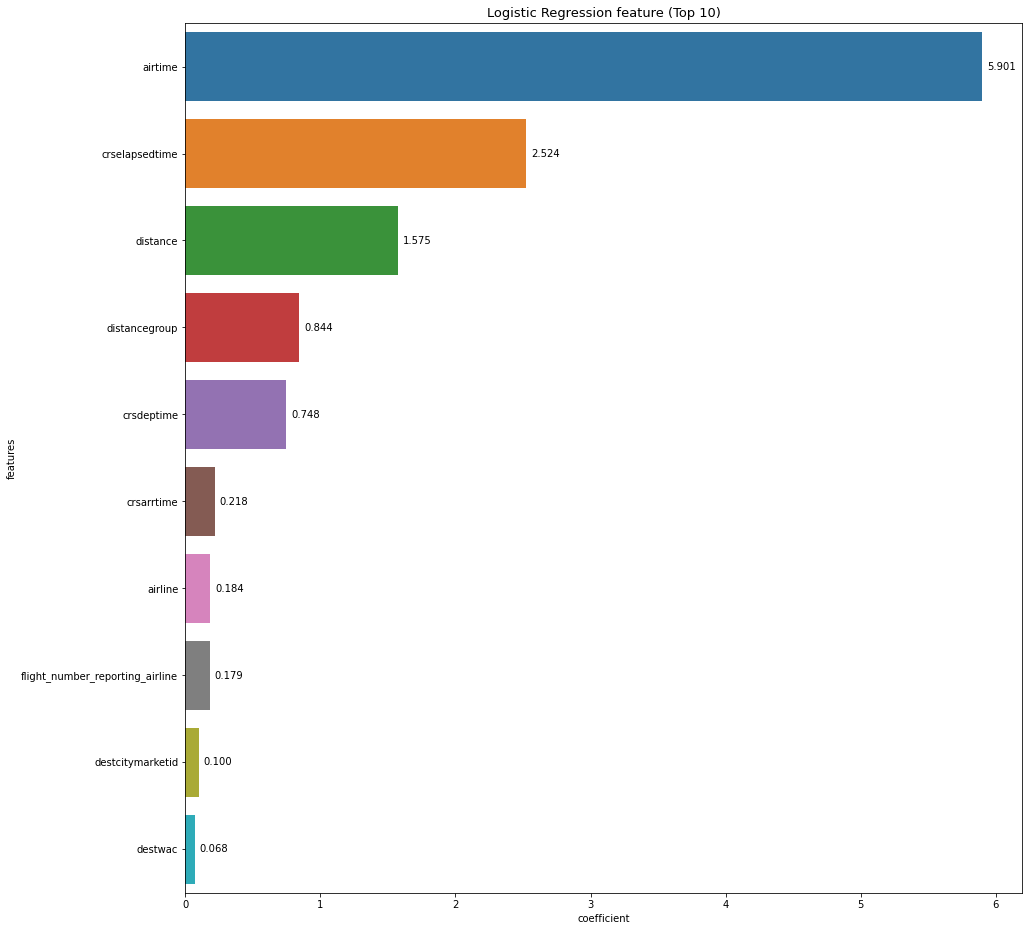

In [23]:
plt.figure(figsize = (15,16))  
ax = sns.barplot(y= feature_importance['features'], x = feature_importance['coefficient'],data = feature_importance)
plt.title('Logistic Regression feature (Top 10)', fontsize = 13)
rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. 
    space = 5

    # Vertical alignment.
    ha = 'left'

    # Use X value as label and format number with one decimal place
    label = "{:.3f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

## Random forest

In [24]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

rf_pipe = make_pipeline(RandomForestClassifier(random_state=42))

# define grid params for random forest classifier
rf_params = {
    'randomforestclassifier__n_estimators':[20,50,100],
    'randomforestclassifier__max_depth':[5,20,50],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__max_leaf_nodes':[5,10,15],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_rf = GridSearchCV(rf_pipe, param_grid = rf_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [25]:
grid_rf.fit(x_train_t,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [5, 20, 50],
                         'randomforestclassifier__max_leaf_nodes': [5, 10, 15],
                         'randomforestclassifier__n_estimators': [20, 50, 100]},
             scoring='roc_auc', verbose=1)

In [26]:
print("best score", grid_rf.best_score_)
print("best params", grid_rf.best_params_)

best score 0.6308000151432023
best params {'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_leaf_nodes': 15, 'randomforestclassifier__n_estimators': 100}


Training Score: 0.648450557345783
Testing Score: 0.6355928890491848


              precision    recall  f1-score   support

         0.0       0.87      0.54      0.67      7959
         1.0       0.25      0.64      0.36      1877

    accuracy                           0.56      9836
   macro avg       0.56      0.59      0.51      9836
weighted avg       0.75      0.56      0.61      9836



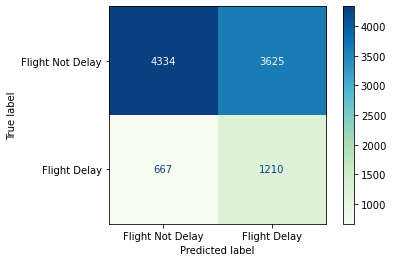

In [27]:
score(grid_rf, x_train_t, x_test_t)

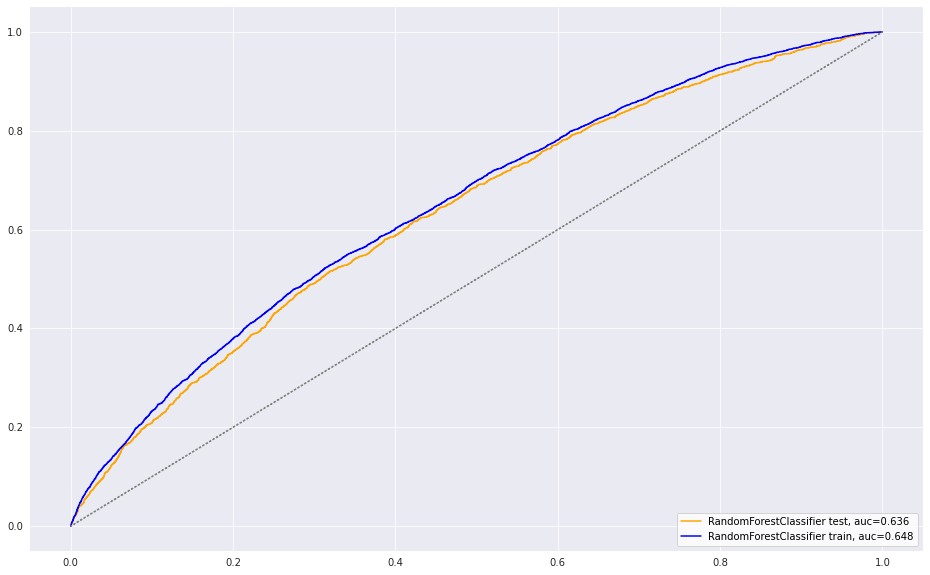

In [28]:
roc(grid_rf,"RandomForestClassifier", x_train_t, x_test_t)

In [29]:
importance = grid_rf.best_estimator_.named_steps.randomforestclassifier.feature_importances_
importance

array([0.        , 0.00831019, 0.04164517, 0.0171187 , 0.00289703,
       0.02412075, 0.02751268, 0.01024263, 0.00864054, 0.02540401,
       0.36494577, 0.32532265, 0.02308757, 0.0430538 , 0.        ,
       0.02240326, 0.00708216, 0.04821307])

In [30]:
feature_importance_rf = pd.DataFrame({'features' :x_train.columns,
                                   'feature_importances' : abs(importance)}).sort_values(by='feature_importances',
                                                                                         ascending = False)

In [31]:
feature_importance_rf['rank'] = feature_importance_rf['feature_importances'].rank(ascending = False)
feature_importance_rf = feature_importance_rf[:10]
feature_importance_rf

,features,feature_importances,rank
10,crsdeptime,0.364946,1.0
11,crsarrtime,0.325323,2.0
17,airline,0.048213,3.0
13,airtime,0.043054,4.0
2,month,0.041645,5.0
6,originairportid,0.027513,6.0
9,destwac,0.025404,7.0
5,flight_number_reporting_airline,0.024121,8.0
12,crselapsedtime,0.023088,9.0
15,distance,0.022403,10.0


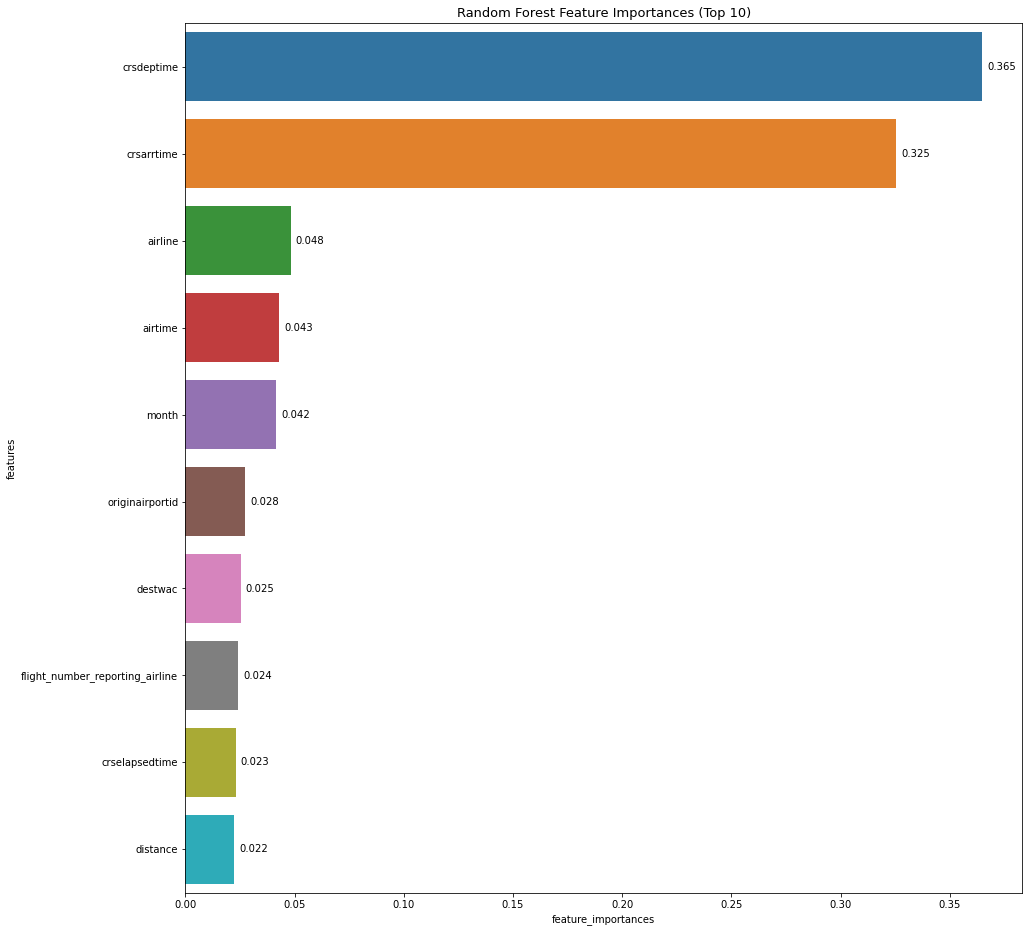

In [32]:
plt.figure(figsize = (15,16))  
ax = sns.barplot(y= feature_importance_rf['features'], x = feature_importance_rf['feature_importances'],data = feature_importance_rf)
plt.title('Random Forest Feature Importances (Top 10)', fontsize = 13)
rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. 
    space = 5

    # Vertical alignment.
    ha = 'left'

    # Use X value as label and format number with one decimal place
    label = "{:.3f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()